### xy function fitting

In [4]:
import matplotlib.pyplot as plt
import torch.cuda

from kan import KAN, create_dataset

# Let's set the device to be used for the dataset generation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

def xy(x):
    return x[:, [0]] * x[:, [1]]

In [5]:
dataset = create_dataset(
    f=xy,
    n_var=2,
    train_num=10000,
    test_num=1000,
    device=device,
    ranges=[(-10, 10), (-10, 10)]
)

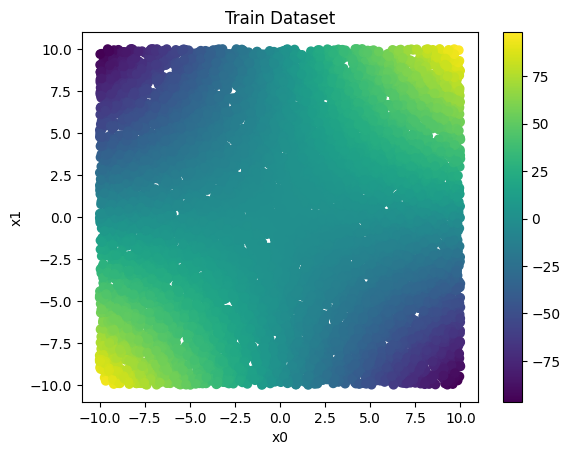

In [6]:
plt.scatter(dataset['train_input'][:, [0]].to('cpu'), dataset['train_input'][:, [1]].to('cpu'),
            c=dataset['train_label'].flatten().to('cpu'), cmap='viridis')
plt.title('Train Dataset')
plt.xlabel('x0')
plt.ylabel('x1')
plt.colorbar()
plt.show()

In [7]:
model = KAN(width=[2, 3, 3, 1], grid=100, k=3, device=device)

r2 is 0.7779091596603394
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.7826252579689026
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.9846869111061096
r2 is 0.9848194122314453
Best value at boundary.
r2 is 0.9986667633056641
r2 is 0.9976706504821777
Best value at boundary.
r2 is 0.9954747557640076
r2 is 0.9994252920150757
r2 is 0.9984908103942871
r2 is 0.9984245896339417


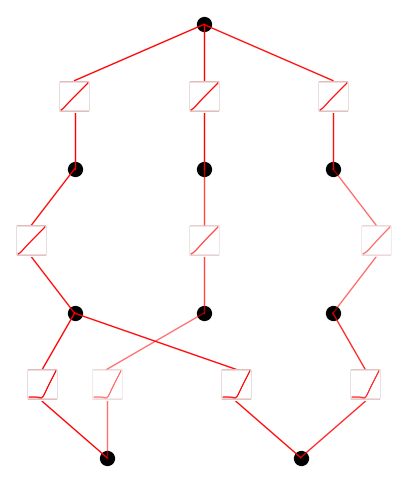

In [8]:
model(dataset['train_input'])
model.fix_symbolic(0, 0, 0, 'x')
model.fix_symbolic(0, 1, 0, 'x')
model.fix_symbolic(0, 0, 1, 'x^2')
model.remove_edge(0, 1, 1)
model.remove_edge(0, 0, 2)
model.fix_symbolic(0, 1, 2, 'x^2')
model.fix_symbolic(1, 0, 0, 'x^2')
model.remove_edge(1, 1, 0)
model.remove_edge(1, 2, 0)
model.remove_edge(1, 0, 1)
model.fix_symbolic(1, 1, 1, 'x')
model.remove_edge(1, 2, 1)
model.remove_edge(1, 0, 2)
model.remove_edge(1, 1, 2)
model.fix_symbolic(1, 2, 2, 'x')
model.fix_symbolic(2, 0, 0, 'x')
model.fix_symbolic(2, 1, 0, 'x')
model.fix_symbolic(2, 2, 0, 'x')
model.plot()

In [9]:
losses = model.train(dataset=dataset, opt='LBFGS', steps=20, device=device)

train loss: 1.27e-05 | test loss: 1.27e-05 | reg: 2.38e+01 : 100%|██| 20/20 [00:31<00:00,  1.57s/it]


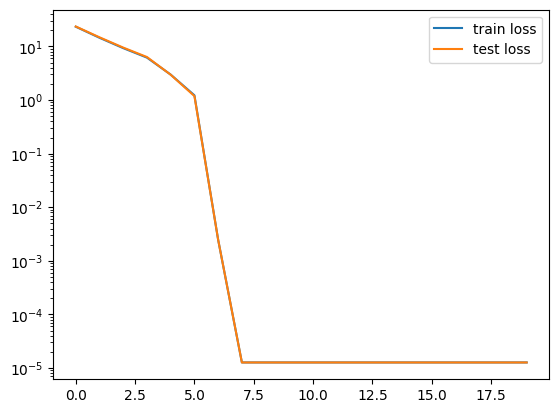

In [10]:
plt.plot(losses['train_loss'], label='train loss')
plt.plot(losses['test_loss'], label='test loss')
plt.legend()
plt.yscale('log')
plt.show()

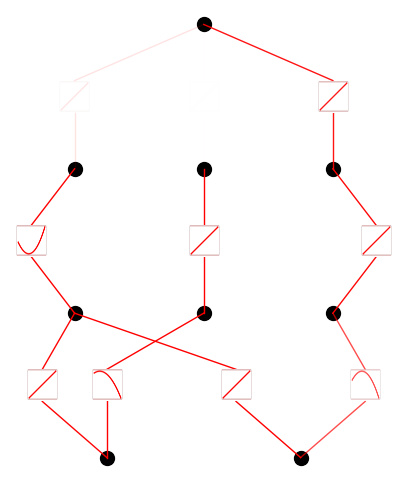

In [11]:
model.plot()

In [12]:
model.symbolic_formula()

make sure all activations need to be converted to symbolic formulas first!


### Analytic function construction

In [14]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

In [15]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

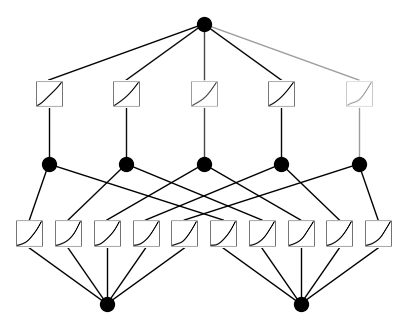

In [16]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100)

In [17]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

train loss: 1.32e-01 | test loss: 1.38e-01 | reg: 2.65e+01 : 100%|██| 20/20 [00:12<00:00,  1.64it/s]


{'train_loss': [array(0.26818845, dtype=float32),
  array(0.17456055, dtype=float32),
  array(0.14455795, dtype=float32),
  array(0.14160386, dtype=float32),
  array(0.13518217, dtype=float32),
  array(0.13887753, dtype=float32),
  array(0.13581155, dtype=float32),
  array(0.14125492, dtype=float32),
  array(0.13429235, dtype=float32),
  array(0.13328308, dtype=float32),
  array(0.13507283, dtype=float32),
  array(0.1364994, dtype=float32),
  array(0.13653354, dtype=float32),
  array(0.13520329, dtype=float32),
  array(0.13026792, dtype=float32),
  array(0.1414494, dtype=float32),
  array(0.13636084, dtype=float32),
  array(0.1388195, dtype=float32),
  array(0.13057506, dtype=float32),
  array(0.13214792, dtype=float32)],
 'test_loss': [array(0.27684557, dtype=float32),
  array(0.17429656, dtype=float32),
  array(0.15060724, dtype=float32),
  array(0.14552556, dtype=float32),
  array(0.13290647, dtype=float32),
  array(0.13716537, dtype=float32),
  array(0.13476641, dtype=float32),
  a

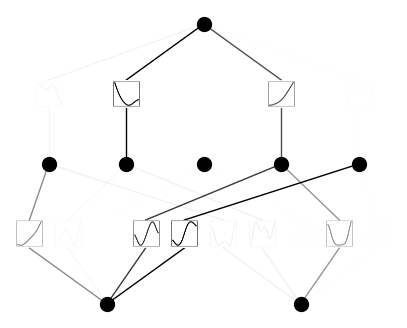

In [18]:
model.plot()

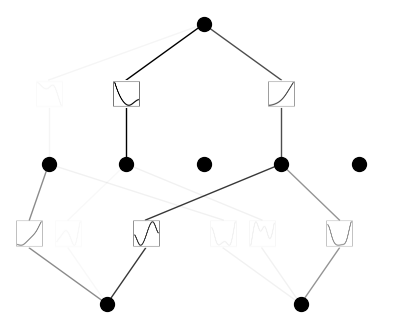

In [19]:
model.prune()
model.plot(mask=True)

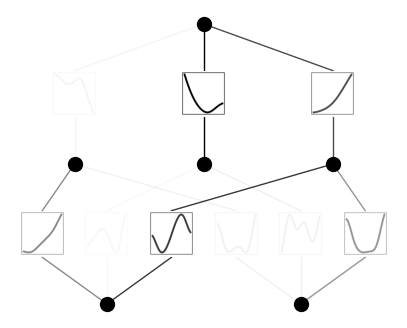

In [20]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [21]:
model.train(dataset, opt="LBFGS", steps=50)

train loss: 3.34e-03 | test loss: 3.58e-03 | reg: 9.23e+00 : 100%|██| 50/50 [00:21<00:00,  2.28it/s]


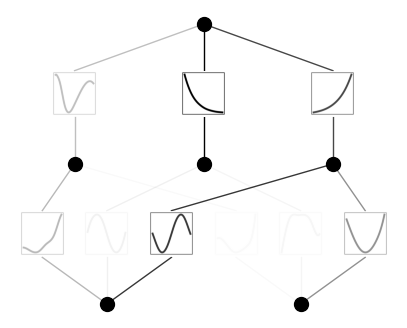

In [22]:
model.plot()

In [26]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

skipping (0,0,0) since already symbolic
skipping (0,0,1) since already symbolic
skipping (0,0,2) since already symbolic
skipping (0,1,0) since already symbolic
skipping (0,1,1) since already symbolic
skipping (0,1,2) since already symbolic
skipping (1,0,0) since already symbolic
skipping (1,1,0) since already symbolic
skipping (1,2,0) since already symbolic


In [24]:
model.train(dataset, opt="LBFGS", steps=50)

train loss: 3.09e-02 | test loss: 3.10e-02 | reg: 1.00e+01 : 100%|██| 50/50 [00:06<00:00,  7.80it/s]


{'train_loss': [array(0.03285654, dtype=float32),
  array(0.03092631, dtype=float32),
  array(0.03092622, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.03092586, dtype=float32),
  array(0.0309

In [25]:
model.symbolic_formula()[0][0]

0.13*sin(3.27*(-x_1 - 0.41)**2 + 0.66*(-x_2 - 0.05)**2 - 10.82) + 22.84*tanh(0.5*(0.03 - x_2)**4 + 0.55*sin(3.06*x_1) - 3.16) + 512.06*tanh(0.46*(-x_2 - 0.e-2)**2 + 0.48*sin(3.18*x_1) - 3.42) + 534.66

### Oscillatior

In [ ]:
def exact_solution(d, w0, t):
    '''
    Defines the analytical solution to the under-damped harmonic 
    oscillator problem above.
    '''
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [ ]:
# Define boundary points for the boundary loss
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# Define training points over the entire domain for the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# Define the parameters in the PDE
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Arrays for validating
t_test = torch.linspace(0, 1, 100).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

In [27]:
def loss_fn(u_pred, y):
    lambda1, lambda2 = 1e-1, 1e-4

    # Compute the boundary loss
    # u_pred = pinn(t_boundary)
    # loss1 = (torch.squeeze(u_pred) - 1)**2
    # dudt = torch.autograd.grad(u_pred, t_boundary, torch.ones_like(u_pred), create_graph=True)[0]
    # loss2 = (torch.squeeze(dudt) - 0)**2

    # Compute the physics loss
    dudt = torch.autograd.grad(u_pred, t_physics, torch.ones_like(u_pred), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u_pred)**2)

    # Compute the total loss
    # loss = loss1 + lambda1*loss2 + lambda2*loss3

    return lambda2*loss3

In [ ]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape
dataset['train_label'].shape